# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a Data Challenge 3 GRB (GRB 080802386) simulated using MEGAlib and combined with albedo photon background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 80% polarization at an angle of 90 degrees in the IAU convention, and was 20 degrees off-axis. A detailed description of the Stokes method, which is the approach used here to infer the polarization, is available on the [Data Challenge repository](https://github.com/cositools/cosi-data-challenges/tree/main/polarization). 

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization.polarization_stokes import PolarizationStokes

from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from cosipy.util import fetch_wasabi_file
from pathlib import Path

16:53:39 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=586978;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=541896;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=26884;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=933098;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=932371;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=888178;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=435984;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=434273;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=481784;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=935617;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=416061;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=218512;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=903647;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=831653;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

16:53:39 WARNING   ROOT minimizer not available                                                ]8;id=678893;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=403781;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=466847;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=18712;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=97112;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=581466;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=838976;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=480753;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=904399;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=519019;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=673115;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=605904;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=942903;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=899687;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=472663;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=735368;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=433911;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=464956;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=964216;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=428649;file:///Users/mnegro/opt/anaconda3/envs/test2_stokesmethod_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

### Download and read in data

Download data (same as ASAD method tutorial: if you have already downloaded them you don't need to run these lines)

In [2]:
# fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/polarization_fit/grb_background.fits.gz', checksum = '21b1d75891edc6aaf1ff3fe46e91cb49')
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.pol.e200_10000.b4.p12.relx.s10396905069491.m420.filtered.nonsparse.binnedpolarization.11D_nside8.area.good_chunks.h5.zip', unzip = True, checksum = '9c1309efec9a37afdcd49b7a443b280b')
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori', checksum = 'b87fd41b6c28a5c0c51448ce2964e57c')

Read in the data (GRB+background) and get the background by reading the files containting background before and after the GRB

In [3]:
data_path = Path("/Users/mnegro/MyDocuments/_COSI/COSIpy/eliza_pull_request_updated/cosipy/docs/tutorials/polarization/") # Update to your path

grb_plus_background = UnBinnedData(data_path/'grb.yaml')
grb_plus_background.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'grb_background_source_interval') 
grb_plus_background.select_data_energy(200., 10000., output_name=data_path/'grb_background_source_interval_energy_cut', unbinned_data=data_path/'grb_background_source_interval.fits.gz')
data = grb_plus_background.get_dict_from_fits(data_path/'grb_background_source_interval_energy_cut.fits.gz')

background_before = UnBinnedData(data_path/'background_before.yaml')
background_before.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'background_before')
background_before.select_data_energy(200., 10000., output_name=data_path/'background_before_energy_cut', unbinned_data=data_path/'background_before.fits.gz')
background_1 = background_before.get_dict_from_fits(data_path/'background_before_energy_cut.fits.gz')

background_after = UnBinnedData(data_path/'background_after.yaml') # e.g. background_after.yaml
background_after.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'background_after')
background_after.select_data_energy(200., 10000., output_name=data_path/'background_after_energy_cut', unbinned_data=data_path/'background_after.fits.gz')
background_2 = background_after.get_dict_from_fits(data_path/'background_after_energy_cut.fits.gz')

background = [background_1, background_2]

Read in the response files and the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin ( The orientation is cut down to the time interval of the source.)

In [4]:
response_file = data_path/'ResponseContinuum.o3.pol.e200_10000.b4.p12.relx.s10396905069491.m420.filtered.nonsparse.binnedpolarization.11D_nside8.area.good_chunks.h5' # e.g. ResponseContinuum.o3.pol.e200_10000.b4.p12.s10396905069491.m441.filtered.nonsparse.binnedpolarization.11D_nside8.area.h5

sc_orientation = SpacecraftFile.parse_from_file(data_path/'DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori') # e.g. DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori
sc_orientation = sc_orientation.source_interval(Time(1835493492.2, format = 'unix'), Time(1835493492.8, format = 'unix'))

Define the GRB spectrum. This is convolved with the response to calculate the ASADs of an unpolarized and 100% polarized source

In [5]:
source_direction = SkyCoord(l=23.53, b=-53.44, frame='galactic', unit=u.deg)

a = 100. * u.keV
b = 10000. * u.keV
alpha = -0.7368949
beta = -2.095031
ebreak = 622.389 * u.keV
K = 300. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

Define the source position and polarization object

In [6]:
source_photons = PolarizationStokes(source_direction, spectrum, data, background, response_file, sc_orientation, response_convention='RelativeX')

This class loading takes around 30 seconds... 

>>> Convolving spectrum in ICRS frame...


Let's check some numbers:

In [7]:
data_duration = source_photons.get_data_duration()
print('\nData duration:', str(round(data_duration, 3)), 's')

background_duration = source_photons.get_background_duration()
print('\nBackground duration:', str(round(background_duration, 3)), 's')

MDP99 = source_photons._mdp99 * 100
print('\nMDP_99:', str(round(MDP99, 3)), '%')


Data duration: 0.541 s

Background duration: 378.9 s

MDP_99: 11.298 %


Derive the modulation factor. This depends on the source spectrum and the instrument polarization response averaged over polarization angles. This steo needs to be re-computed for every source.

Creating the 100% polarized ASADs (this may take a minute...)


Creating the unpolarized ASAD...
A = 0.72, B = 0.56, C = 1.55
Rmax, Rmin: 1.2765994095848665 0.7208759491498263
Modulation mu =  0.2782129241319227
A = 0.71, B = 0.57, C = 1.28
Rmax, Rmin: 1.277565221044138 0.7145656302116623
Modulation mu =  0.2826117523743843
A = 0.71, B = 0.58, C = 1.02
Rmax, Rmin: 1.2811347880756978 0.7115098904640041
Modulation mu =  0.2858637587254843
A = 0.71, B = 0.58, C = 0.76
Rmax, Rmin: 1.2832547944023935 0.7105732262477737
Modulation mu =  0.28722716414020205
A = 0.71, B = 0.58, C = 0.50
Rmax, Rmin: 1.286333723259795 0.709611209311379
Modulation mu =  0.2889471069752825
A = 0.71, B = 0.57, C = 0.25
Rmax, Rmin: 1.2795091218061168 0.7209409818293889
Modulation mu =  0.27922123074283006
A = 1.28, B = -0.57, C = 1.54
Rmax, Rmin: 1.2816992490648778 0.7193171518560963
Modulation mu =  0.2810482197696847
A = 1.28, B = -0.57, C = 1.28
Rmax, Rmin: 1.282324586598261 0.724706750909539
Modulation mu =  0.2778321520286452
A = 1.29, B = -0.58, C = 1.02
Rmax, Rmin: 1.2897

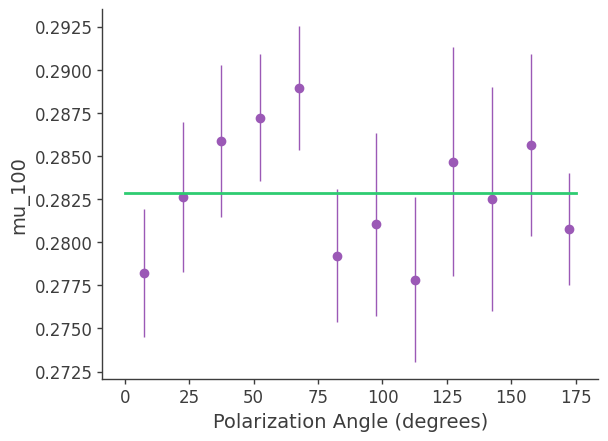

modularion factor: {mu:.2f} +/- {mu_err:.2f} %


In [8]:
average_mu = source_photons.calculate_average_mu100(show_plots=True) 
mu = average_mu['mu'] #0.310
mu_err = average_mu['uncertainty'] #0.001

print('modularion factor: {mu:.2f} +/- {mu_err:.2f} %')

Get the azimuthal angles for each photons and calculate the Pseudo Stokes parameters from the scattering angle for each photon in the data and background simulation

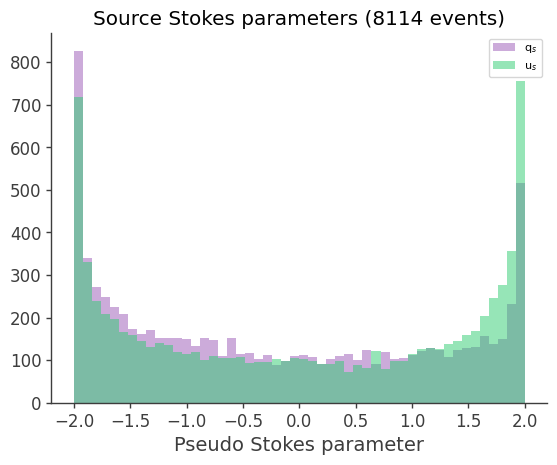

In [9]:
qs, us = source_photons.compute_data_pseudo_stokes(show=True)

Now get the stokes parameters for the background observations

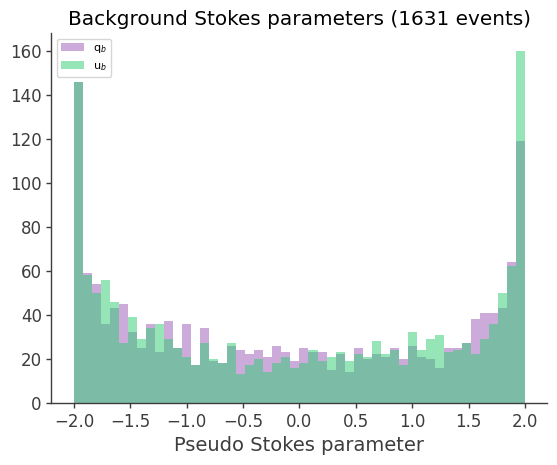

In [10]:
bkg_qs, bkg_us = source_photons.compute_background_pseudo_stokes(show=True)

The background is rate is estimated over a longer time period and therefore its flux needs to be rescaled to the expected flux during the GRB.

This factor is simply computed as the ration of GRB duration / background duration.

In [11]:
backscal = source_photons.get_backscal()

print('Background scale factor:', backscal)
print('Consistency check :', data_duration/background_duration == backscal)

Background scale factor: 0.0014270214696478288
Consistency check : True


Compute the expected MDP assuming 

Q, U unpolarized: -0.3128133204998456 -0.12947028597215868
unpol_uncertainty: 432.93677967024655 %
check I_src+bkg vs Isrc: 8114 8111.672527983004
Q, U, subtracted: -0.8131920884754699 0.09626674069045373
PD: 81.89 +/- 5.48 %
PA: 86.62 +/- 1.94 deg
Drawing Reference point: (0.8, 90)


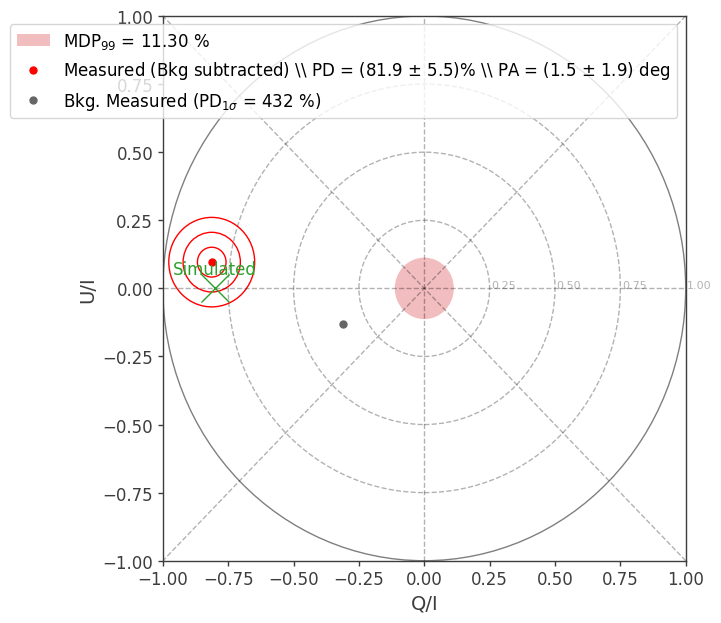

In [12]:
polarization = source_photons.calculate_polarization(qs, us, bkg_qs, bkg_us, mu, show_plots=True, ref_pdpa=(0.8, 90), ref_label='Simulated', mdp=MDP99/100)


Extracting the informations from the polarization dictionary:

In [ ]:
PD = polarization['fracion'] * 100
PD_err = polarization['polarization_fraction_uncertainty'] * 100
print('Polarization degree: {PD:.2f} +/- {PD_err:.2f} %')

pPA = polarization.angle
pPA_err = polarization['polarization_angle_uncertainty']
print('Polarization angle: {pPA:.2f} +/- {pPA_err:.2f} deg')

Normalized_Q = polarization['QN']
Normalized_U = polarization['UN']

AttributeError: 'dict' object has no attribute 'fraction'